# Imports

In [43]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# Set Paths

In [44]:
# Define the project path and a list of 5 ABF file names
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'

# Load Data

In [45]:
# Load the ABF file
abf = pyabf.ABF(f'{project_path}DS4CNQX ACCOM.abf')
sweep_numbers = [0, 4, 7]

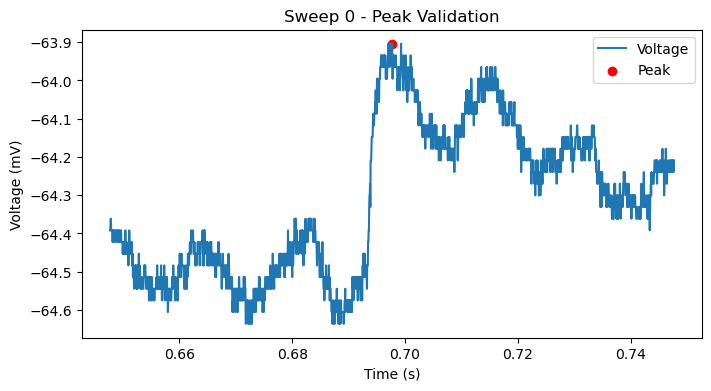

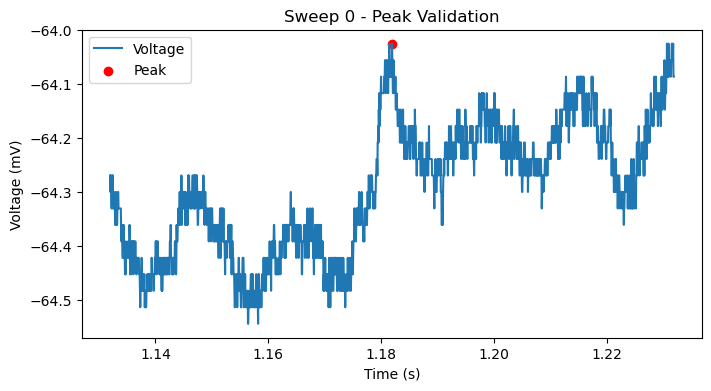

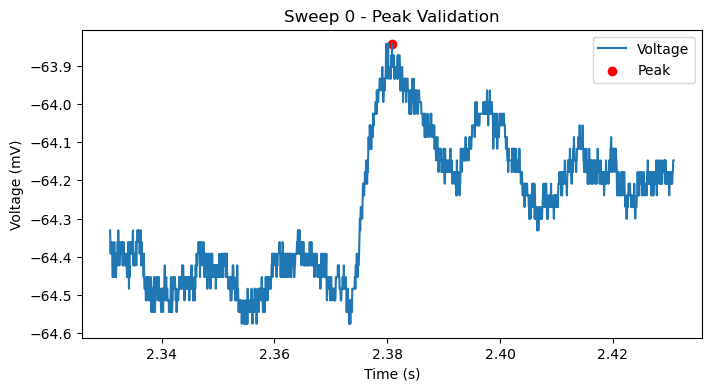

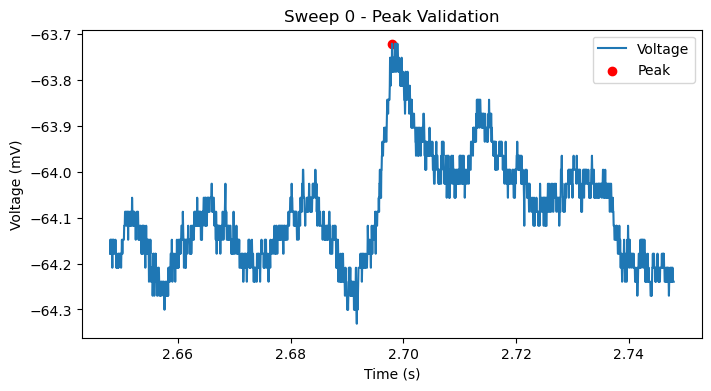

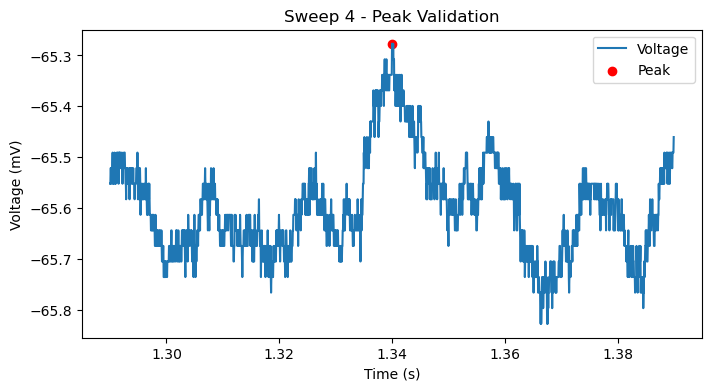

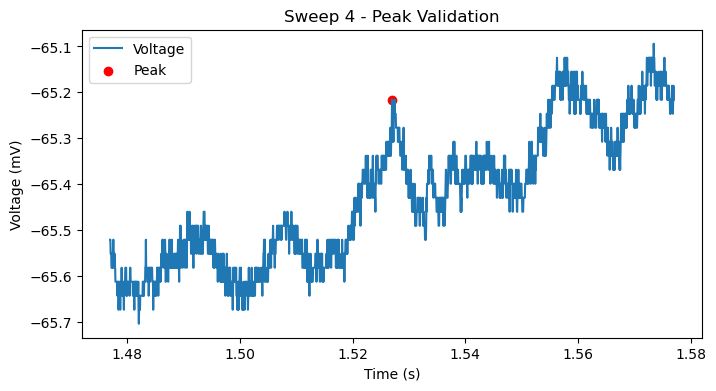

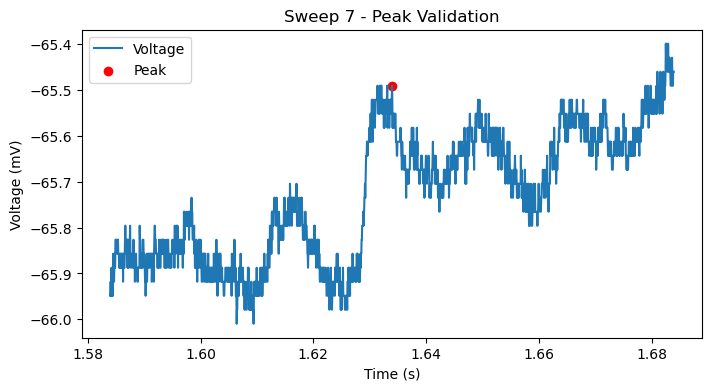

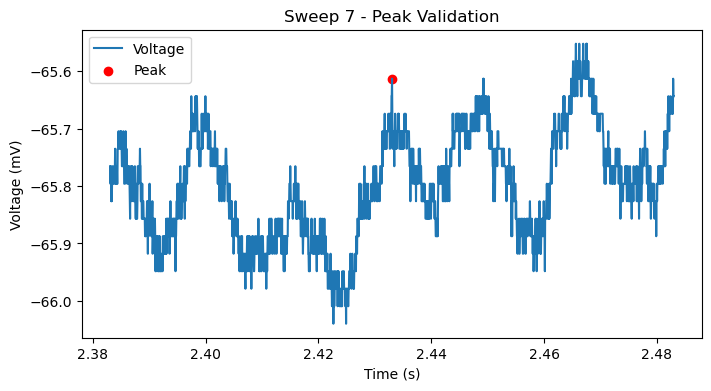

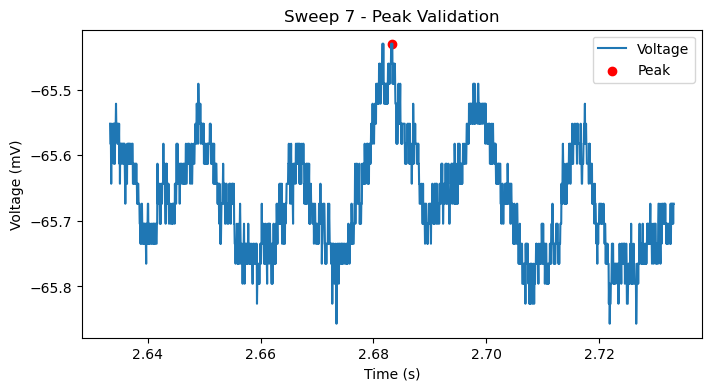

Sweep 0: Number of validated peaks: 4, Average amplitude: 0.58 mV
Sweep 4: Number of validated peaks: 1, Average amplitude: 0.42 mV
Sweep 7: Number of validated peaks: 1, Average amplitude: 0.41 mV

Overall average amplitude across all sweeps: 0.52 mV
Average number of validated peaks per sweep: 2.00


In [46]:
# Define analysis parameters
start_time = 0.1  # Start time in seconds
end_time = 3.1  # End time in seconds
time_window = 0.02  # Time window in seconds (30 ms)

# Function to find peaks using scipy's find_peaks
def find_peaks_robust(times, voltage, time_window):
    sampling_interval = times[1] - times[0]  # Calculate sampling interval (seconds per sample)
    distance_samples = int(time_window / sampling_interval)  # Convert time window to samples
    
    # Use scipy's find_peaks with prominence and distance criteria
    peaks, properties = find_peaks(voltage, distance=distance_samples, prominence=0.1)
    
    # Return peak indices and their properties
    return peaks, properties

# Function to check if a peak has a local minimum 0.3mV less within 15ms before or after
def has_local_minimum(voltage, peak_idx, sampling_rate):
    window = int(0.015 * sampling_rate)  # 15ms window
    start = max(0, peak_idx - window)
    end = min(len(voltage), peak_idx + window + 1)
    
    before_min = np.min(voltage[start:peak_idx])
    after_min = np.min(voltage[peak_idx+1:end])
    
    return (voltage[peak_idx] - before_min >= 0.4) or (voltage[peak_idx] - after_min >= 0.4)

# Initialize dictionary to store validated peaks and their amplitudes
validated_peaks = {}
peak_amplitudes = {}

# Loop through each sweep
for sweep in sweep_numbers:
    abf.setSweep(sweep, channel=0)
    
    # Extract voltage and time data
    times = abf.sweepX
    voltage = abf.sweepY
    
    # Find indices corresponding to the desired time segment
    start_index = np.argmin(np.abs(times - start_time))
    end_index = np.argmin(np.abs(times - end_time))
    
    segment_times = times[start_index:end_index]
    segment_voltage = voltage[start_index:end_index]
    
    # Find peaks in this segment using the robust method
    peak_indices, properties = find_peaks_robust(segment_times, segment_voltage, time_window)
    
    # Filter peaks based on local minimum criteria
    sampling_rate = 1 / (segment_times[1] - segment_times[0])
    filtered_peak_indices = [idx for idx in peak_indices if has_local_minimum(segment_voltage, idx, sampling_rate)]
    
    # Validate each filtered peak interactively and get baseline
    validated_peak_data = []
    for peak_idx in filtered_peak_indices:
        # Zoomed-in plot around the peak
        zoom_window_samples = int(0.05 / (segment_times[1] - segment_times[0]))  # +/-50 ms window
        start_zoom_idx = max(peak_idx - zoom_window_samples, 0)
        end_zoom_idx = min(peak_idx + zoom_window_samples, len(segment_voltage))
        
        plt.figure(figsize=(8, 4))
        plt.plot(segment_times[start_zoom_idx:end_zoom_idx], segment_voltage[start_zoom_idx:end_zoom_idx], label='Voltage')
        plt.scatter(segment_times[peak_idx], segment_voltage[peak_idx], color='red', label='Peak')
        plt.title(f'Sweep {sweep} - Peak Validation')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (mV)')
        plt.legend()
        plt.show()
        
        # Prompt user for validation
        response = input(f"Accept this peak at {segment_times[peak_idx]:.3f}s (y/n)? ").strip().lower()
        if response == 'y':
            baseline = float(input("Enter baseline voltage for this peak (mV): "))
            peak_time = segment_times[peak_idx]
            peak_voltage = segment_voltage[peak_idx]
            amplitude = peak_voltage - baseline
            validated_peak_data.append((peak_time, peak_voltage, baseline, amplitude))
    
    # Store validated peaks and amplitudes for this sweep
    validated_peaks[sweep] = validated_peak_data
    peak_amplitudes[sweep] = [data[3] for data in validated_peak_data]

# Report the number of validated peaks and average amplitude for each sweep
for sweep in sweep_numbers:
    num_peaks = len(validated_peaks[sweep])
    avg_amplitude = np.mean(peak_amplitudes[sweep]) if peak_amplitudes[sweep] else 0
    print(f"Sweep {sweep}: Number of validated peaks: {num_peaks}, Average amplitude: {avg_amplitude:.2f} mV")

# Calculate and print the overall average amplitude across all sweeps
all_amplitudes = [amp for sweep_amps in peak_amplitudes.values() for amp in sweep_amps]
overall_avg_amplitude = np.mean(all_amplitudes) if all_amplitudes else 0
print(f"\nOverall average amplitude across all sweeps: {overall_avg_amplitude:.2f} mV")

# Calculate and print the average number of validated peaks per sweep
total_peaks = sum(len(peaks) for peaks in validated_peaks.values())
avg_peaks_per_sweep = total_peaks / len(sweep_numbers) if sweep_numbers else 0
print(f"Average number of validated peaks per sweep: {avg_peaks_per_sweep:.2f}")